In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [2]:
# Load CSV
df = pd.read_csv('Daily Data Receipt Count Prediction.csv')
df_int = df.apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)
data = df_int.iloc[:, 1].values.reshape(-1, 1) # convert to an array of daily Receipt Count
dataTensor = torch.tensor(data, dtype=torch.float32) # convert to torch

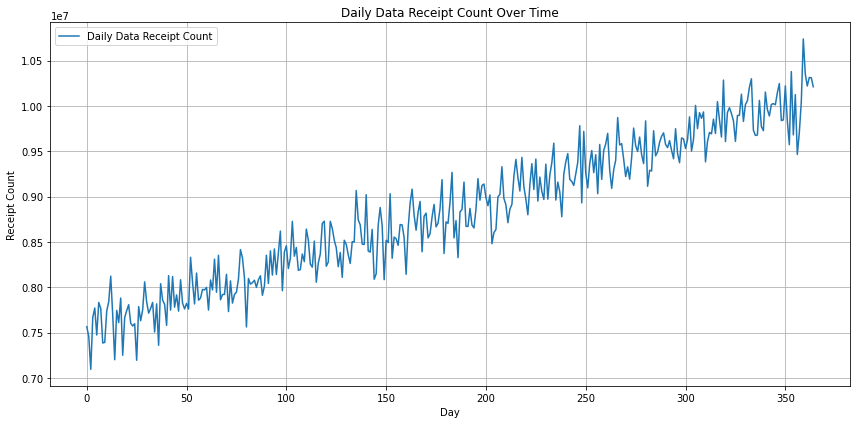

In [3]:
# Plotting all
plt.figure(figsize=(12, 6))
plt.plot(dataTensor, label='Daily Data Receipt Count')
plt.title('Daily Data Receipt Count Over Time')
plt.xlabel('Day')
plt.ylabel('Receipt Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Thoughts about the data

The data clearly looks linear with some noise. I hypothesise that the data can be modeled by a simple Guassian Conditional Model. The data looks something like the following graph of dummy data:

![Gaussian Conditional Model](DummyGaussianConditionalModel.png)

## A Simple Gaussian Conditional Model

### Regression Model:
$$
y = \underbrace{w_0 + w_1 x}_{f(\mathbf{w}, x)} + \epsilon,\quad \epsilon \sim \mathcal{N}(0, \sigma^2)
$$


**Input:** $ x \in \mathbb{R} $, **Output:** $ y \in \mathbb{R} $
**Model parameter:** $ \mathbf{w} = [w_0, w_1] $

---

### Conditional probability model:
$$
y \sim \mathcal{N}(f(\mathbf{w}, x), 1)
$$

It only models relationship between $ y $ and $ x $, but does not model the probability distribution of $ x $.

In [4]:
# tensor of number of days in each month
window = torch.tensor([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31], device=dataTensor.device)
data_flat = dataTensor.flatten()
monthly_chunks = torch.split(data_flat, window.tolist())# Using tolist to pass into split into chunks of ith window 
monthly_actual_sums = torch.stack([chunk.sum() for chunk in monthly_chunks]) # Computing sums for each month

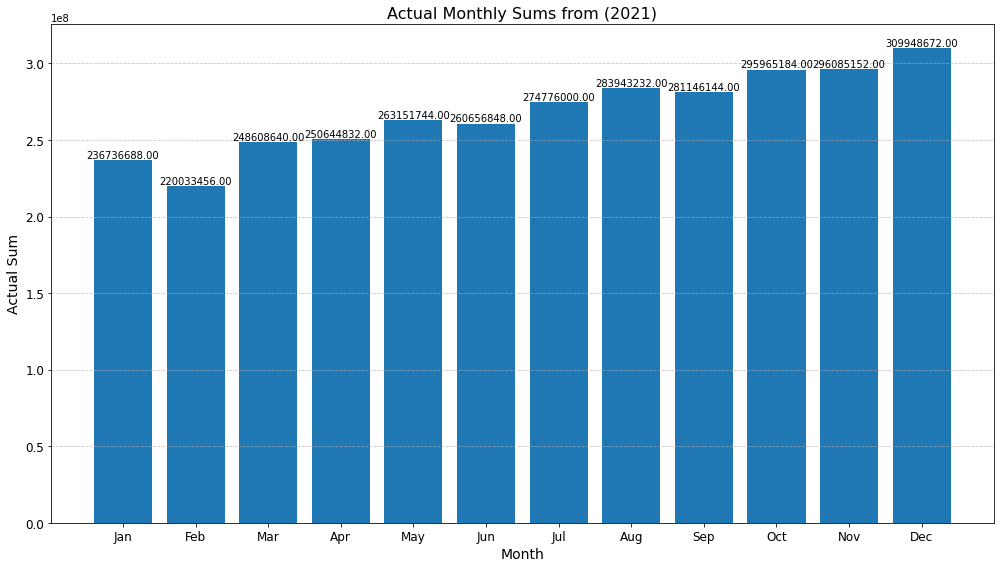

In [5]:
# Plotting monthly sums
plt.figure(figsize=(14, 8))
bars = plt.bar(range(1, 13), monthly_actual_sums)

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5, f"{height:.2f}",
             ha='center', va='bottom', fontsize=10)

plt.xlabel("Month", fontsize=14)
plt.ylabel("Actual Sum", fontsize=14)
plt.title("Actual Monthly Sums from (2021)", fontsize=16)
plt.xticks(ticks=range(1, 13), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# LEAST SQUARES REGRESSION

This kind of data is usually best modelled by Least Squares Regression. I have not shown the work for derivation, Maximum Likelihood Estimate or Optimization for the least squares here since it is a very basic model, especially when working with python. 

In [6]:
data = dataTensor.flatten().unsqueeze(1)  #transposes to a vector (in the mathematical sense)

days = torch.arange(1, 366, dtype=data.dtype, device=data.device).unsqueeze(1)  #numbers from 1 to 365
ones = torch.ones_like(days)  # tensor of ones
A = torch.hstack((days, ones))  # makes the matrix A for solving Ax=b, by concatenating the two vectors

# Least squares solution
x = torch.linalg.lstsq(A, data).solution  #simple least squares
m, b = x[0].item(), x[1].item() # extracts variables m and b from slope intercept format

# model from day 1 to 365 and predict from 366 to 730
extended_days = torch.arange(1, 731, dtype=data.dtype, device=data.device).unsqueeze(1)  # 
m = torch.tensor(m, dtype=extended_days.dtype, device=extended_days.device) #init
b = torch.tensor(b, dtype=extended_days.dtype, device=extended_days.device)
predicted_values = extended_days * m + b  # Vectorized linear prediction

y = predicted_values[366:] # Values from day 366 to 730 

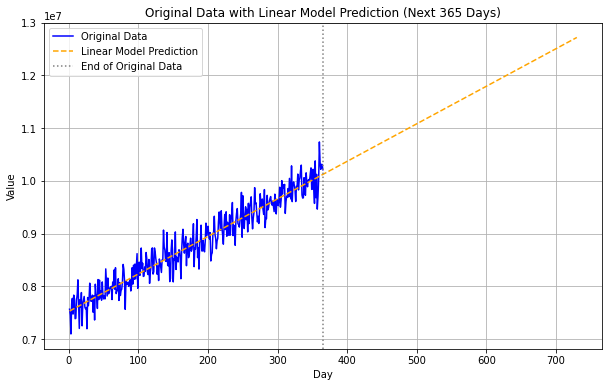

In [7]:
# plotting model and its predictions
plt.figure(figsize=(10, 6))
plt.plot(torch.arange(1, 366).cpu().numpy(), dataTensor.cpu().numpy(), label="Original Data", color='blue')
plt.plot(extended_days.cpu().numpy(), predicted_values.cpu().numpy(), label="Linear Model Prediction", color='orange', linestyle='--')
plt.axvline(x=365, color='gray', linestyle=':', label="End of Original Data")
plt.xlabel("Day")
plt.ylabel("Value")
plt.title("Original Data with Linear Model Prediction (Next 365 Days)")
plt.legend()
plt.grid(True)
plt.show()

Seeing that the Least Squares Regression indeed models the data well, I use half the dataset for trainning and validate predictions using the other half. 

In [8]:
# Initialize train and test tensor filled with NaNs
train_array = torch.full_like(data_flat, float('nan'))
test_array = torch.full_like(data_flat, float('nan'))

block_size = 30
num_blocks = (len(data_flat) + block_size - 1) // block_size  # ceil division

for i in range(num_blocks): #adding alternating blocks of 30 to train and test tensors
    start = i * block_size
    end = min(start + block_size, len(data_flat))
    if i % 2 == 0:
        train_array[start:end] = data_flat[start:end]
    else:
        test_array[start:end] = data_flat[start:end]

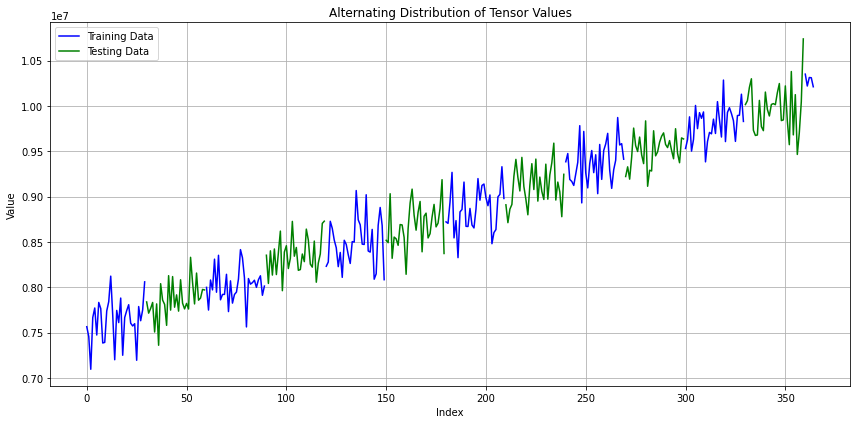

In [9]:
#Plotting the train and test tensors
plt.figure(figsize=(12, 6))
plt.plot(train_array.detach().cpu(), color='blue', label='Training Data')
plt.plot(test_array.detach().cpu(), color='green', label='Testing Data')
plt.title('Alternating Distribution of Tensor Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
train_mask = ~torch.isnan(train_array) # ignores NaN

# Get day indices and targets for training
train_days = torch.arange(1, 366, dtype=train_array.dtype, device=train_array.device)[train_mask].unsqueeze(1)
train_targets = train_array[train_mask].unsqueeze(1) 

train_ones = torch.ones_like(train_days)
A_train = torch.cat((train_days, train_ones), dim=1) # matrix A for solving for x in Ax=b

result = torch.linalg.lstsq(A_train, train_targets) # Solve least squares

x = result.solution.squeeze() 
m, b = x[0].item(), x[1].item() #extracting

print("Slope (m):", m)
print("Intercept (b):", b)

Slope (m): 7348.6337890625
Intercept (b): 7484848.5


In [11]:
all_days = torch.arange(1, 366, dtype=train_array.dtype, device=train_array.device).unsqueeze(1) #convert to vector
m_tensor = torch.tensor(m, dtype=all_days.dtype, device=all_days.device) #init
b_tensor = torch.tensor(b, dtype=all_days.dtype, device=all_days.device)

predicted_line = m_tensor * all_days + b_tensor # Compute the predicted line

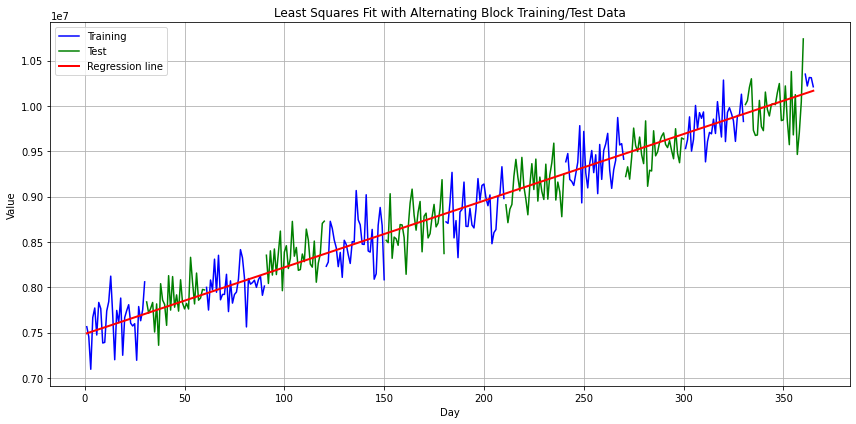

In [12]:
# Plotting how well the model matches the train and test data
plt.figure(figsize=(12, 6))
plt.plot(all_days.cpu().numpy(), train_array.cpu().numpy(), 'b-', label='Training ', markersize=4)
plt.plot(all_days.cpu().numpy(), test_array.cpu().numpy(), 'g-', label='Test', markersize=4)
plt.plot(all_days.cpu().numpy(), predicted_line.cpu().numpy(), 'r-', label='Regression line', linewidth=2)
plt.xlabel("Day")
plt.ylabel("Value")
plt.title("Least Squares Fit with Alternating Block Training/Test Data")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
#Since we want the predictions for the month, not day, we will compare the monthly sums
num_segments = len(test_array) // block_size

actual_sums = []
predicted_sums = []

m_tensor = torch.tensor(m, dtype=test_array.dtype, device=test_array.device)
b_tensor = torch.tensor(b, dtype=test_array.dtype, device=test_array.device)

for i in range(num_segments):
    start = i * block_size
    end = start + block_size

    segment = test_array[start:end]

    if not torch.isnan(segment).all(): #skip nan sections
        # Actual sum (ignoring NaNs)
        actual_sum = torch.nansum(segment)
        actual_sums.append(actual_sum)

        # Predict using regression model
        days_segment = torch.arange(start + 1, end + 1, dtype=segment.dtype, device=segment.device).unsqueeze(1)
        predicted_segment = m_tensor * days_segment + b_tensor
        predicted_sum = predicted_segment.sum()
        predicted_sums.append(predicted_sum)

# Stack results into tensors
actual_sums_tensor = torch.stack(actual_sums)
predicted_sums_tensor = torch.stack(predicted_sums)

differences = actual_sums_tensor - predicted_sums_tensor # compute difference

# Convert lists to torch tensors
actual_sums = torch.tensor(actual_sums)
predicted_sums = torch.tensor(predicted_sums)

# Differences
differences = actual_sums - predicted_sums

Segment 1: Actual = 235842224.00, Predicted = 234576320.00, Diff = 1265904.00
Segment 2: Actual = 250644832.00, Predicted = 247803872.00, Diff = 2840960.00
Segment 3: Actual = 260453760.00, Predicted = 261031424.00, Diff = -577664.00
Segment 4: Actual = 273516992.00, Predicted = 274258944.00, Diff = -741952.00
Segment 5: Actual = 285167840.00, Predicted = 287486496.00, Diff = -2318656.00
Segment 6: Actual = 299120416.00, Predicted = 300714048.00, Diff = -1593632.00


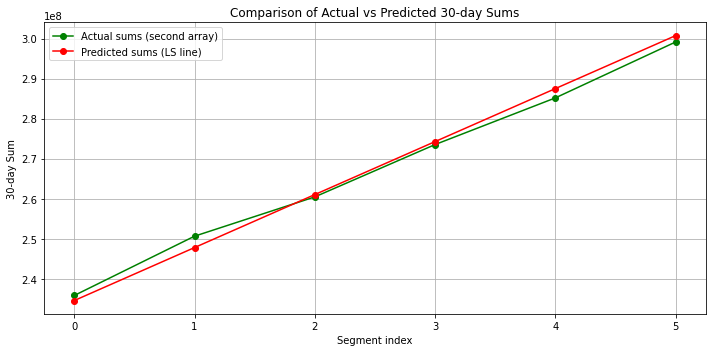

In [14]:
# Print results
for i, (act, pred, diff) in enumerate(zip(actual_sums, predicted_sums, differences)):
    print(f"Segment {i+1}: Actual = {act:.2f}, Predicted = {pred:.2f}, Diff = {diff:.2f}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(actual_sums.numpy(), 'go-', label='Actual sums (second array)')
plt.plot(predicted_sums.numpy(), 'ro-', label='Predicted sums (LS line)')
plt.xlabel("Segment index")
plt.ylabel("30-day Sum")
plt.title("Comparison of Actual vs Predicted 30-day Sums")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We can see that the predicted (least squares line) follows the actual very closely, hence we can conclude that it is a good model

In [15]:
# Predict values for next year (days 366 to 730)
future_days = torch.arange(366, 731, dtype=torch.float32, device=train_array.device).unsqueeze(1)
future_predictions = m * future_days + b  # m and b are Python floats

# Compute monthly predicted sums
start = 0
monthly_predicted_sums = []

# Compute start and end indices for each month
start_indices = torch.cumsum(torch.cat((torch.tensor([0], device=window.device), window[:-1])), dim=0)
end_indices = start_indices + window

# Use slicing to sum over each month's range
monthly_predicted_sums = torch.stack([
    future_predictions[start:end].sum() for start, end in zip(start_indices, end_indices)
])

In [16]:
# Print results
for i, s in enumerate(monthly_predicted_sums):
    print(f"Month {i + 1}: Predicted sum = {s:.2f}")

Month 1: Predicted sum = 318825024.00
Month 2: Predicted sum = 294040960.00
Month 3: Predicted sum = 332265664.00
Month 4: Predicted sum = 328271424.00
Month 5: Predicted sum = 346161920.00
Month 6: Predicted sum = 341719424.00
Month 7: Predicted sum = 360058176.00
Month 8: Predicted sum = 367120256.00
Month 9: Predicted sum = 362001632.00
Month 10: Predicted sum = 381016512.00
Month 11: Predicted sum = 375449632.00
Month 12: Predicted sum = 394912800.00


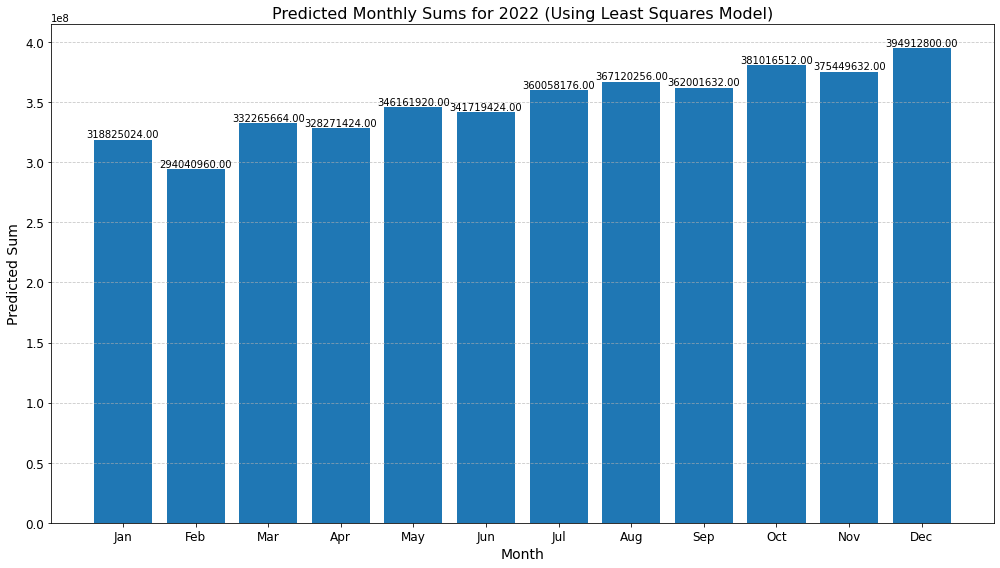

In [17]:
# Plotting predictions for 2022
plt.figure(figsize=(14, 8))
bars = plt.bar(range(1, 13), monthly_predicted_sums)

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5, f"{height:.2f}",
             ha='center', va='bottom', fontsize=10)

plt.xlabel("Month", fontsize=14)
plt.ylabel("Predicted Sum", fontsize=14)
plt.title("Predicted Monthly Sums for 2022 (Using Least Squares Model)", fontsize=16)
plt.xticks(ticks=range(1, 13), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

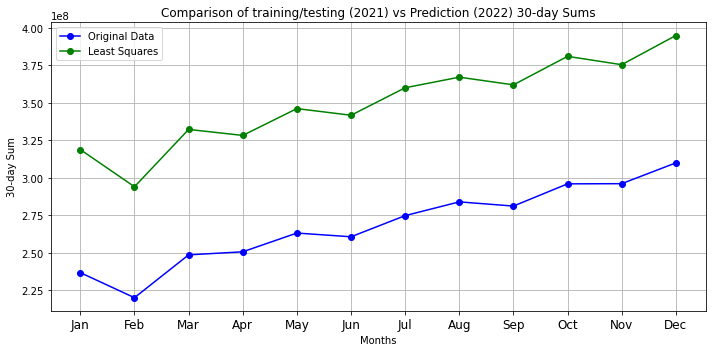

In [18]:
# Plotting sum of 30 days, actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(monthly_actual_sums, 'bo-', label='Original Data')
plt.plot(monthly_predicted_sums, 'go-', label='Least Squares')
plt.xticks(ticks=range(0, 12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
], fontsize=12)
plt.xlabel("Months")
plt.ylabel("30-day Sum")
plt.title("Comparison of training/testing (2021) vs Prediction (2022) 30-day Sums")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

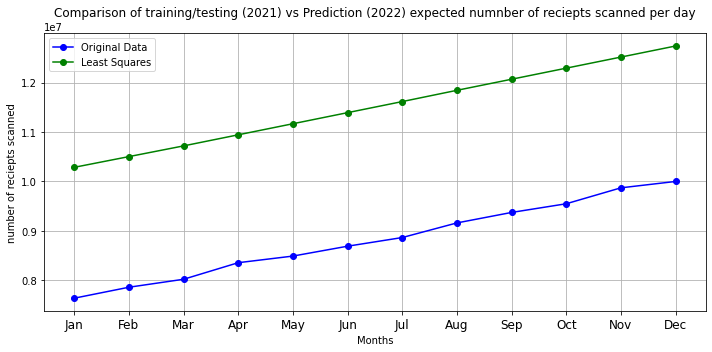

In [19]:
# Plotting expected number of receipts scanned per day in a given month
monthly_actual_avgs = monthly_actual_sums / window # Element-wise division to get averages
monthly_predicted_avgs = monthly_predicted_sums / window

plt.figure(figsize=(10, 5))
plt.plot(monthly_actual_avgs, 'bo-', label='Original Data')
plt.plot(monthly_predicted_avgs, 'go-', label='Least Squares')
plt.xticks(ticks=range(0, 12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
], fontsize=12)
plt.xlabel("Months")
plt.ylabel("number of reciepts scanned")
plt.title("Comparison of training/testing (2021) vs Prediction (2022) expected numnber of reciepts scanned per day")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Observations 

At first glance, there seems to be **overfitting** in the model. The **lack of data may be responsiable for some overfitting**. But, we observe **dips and peaks at exactly the same positions** in both training and test data primarily because of the **variance in the number of days in each month**.

---
### Remarks
I do not model the noise (i.e. variance parameters of the gaussian) because I am only supposed to predict based on month. Summing over a sizable "chunk" of the data set (approximately 30 in this case) cancels out the noise and predicts the data fairly accurately. 

Some things like plotting and splitting into chunks might have had better performance with numpy or similar libraries, however, the instructions said that the excercise was being judged on skilles in PyTorch or TensorFlow, hence, i chose to use PyTorch. 

---

### Additional Factors That May Contribute to Cost Prediction

Here are a few important considerations that i would include given more resources/data:

- **Time of the year**  
  Individuals typically tend to shop more during the end of the year/winter season due to festivals like Halloween, Thanksgiving, Christmas, etc. However, this clearly doesnt seem to be the case. The growth of the company is steadily increasing over the months which brings me to the next point...

- **Growth of the company over the months**  
  As the company grows, it reaches more customers, leading to **more downloads and more receipts scanned per customer**.    

- **Growth of the company over the year**  
  Similar logic applies here.  

- **External economic factors**  
  In 2021, **COVID-19 was at its peak** in the USA. The government provided **stimulus checks (up to $1400)** in April 2021.  
  This resulted in **higher spending** than usual for many households.  
  In contrast, there were **no stimulus checks in 2022**, possibly leading to **lower sales**.